In [1]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import PIQTSP, GED155
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency, software_versions

def show_test_result(passed):
    colour, status = 'green', 'ACCEPTABLE' if passed else 'red', 'FAILED'
    return HTMLLatex(
        f'<b>Test Result - <span style="color:{colour}">{status}</span></b>',
        f'\\textbf{{Test Result -- \\color{{{colour}}}{status}}}'
    )

# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-04-20T16:49:04+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil SNR
- Head Coil Image Uniformity

----

All of the above are acceptable.

----

In [2]:
NewPage

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [3]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid
series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')

display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner              MRL1R1
Date               20200829
Patient  AQA20200829NBTMR11
Study                 10674

In [4]:
text = f'''
{operator}
Medical Physics & Bioengineering, UH Bristol
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo using the crossed _slice profile_ slots in the PIQT phantom.

### 3 mm Slice

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series)
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

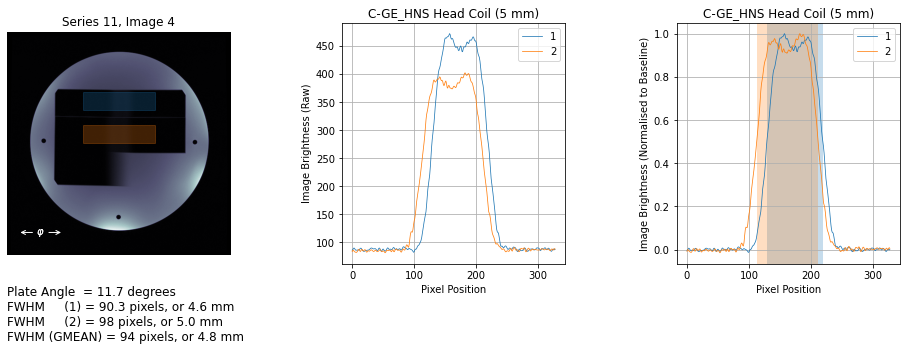

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series)
result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                57.5             2.9
5.0                                94.4             4.8

The profile widths are well within the AAPM tolerance of 0.5mm.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are after applying tha manufacturer's distortion correction.

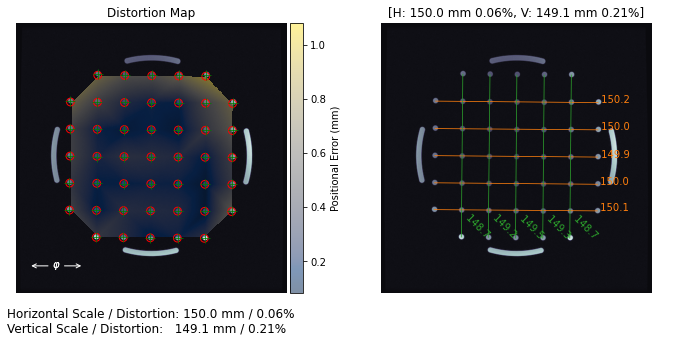

In [9]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

In [10]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
13           Axial              RL        0.511                150.026   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
13                      0.055              149.064                0.214

The scale in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [11]:
NewPage

## Resolution

Image resolution estimated by analysis of the mtf block in PIQT phantom.

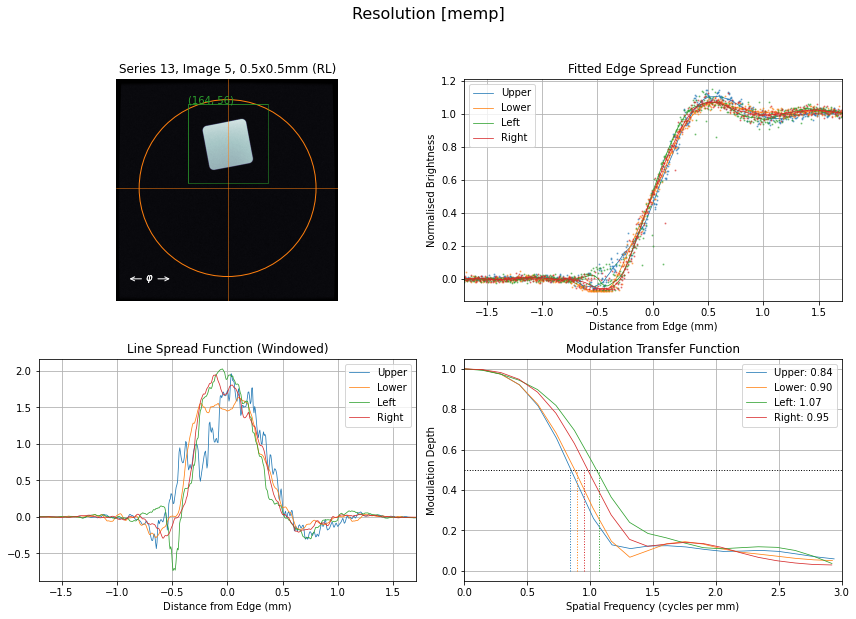

MTF_50
Upper   0.840
Lower   0.896
Left    1.074
Right   0.954

In [12]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']]), key=lambda d: int(d.InstanceNumber))
dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]

results = mtf_report(dobj_mtf, dobj_centre)
plt.show()
results

The MTF_50 is consistent with a pixel size of 0.5mm along the left and right edges of the mtf block but is a little lower than expected across the lower and upper edges. This may imply a slightly degraded resolution in the frequency encode direction or may be a twist in the phantom alignment.

In [13]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

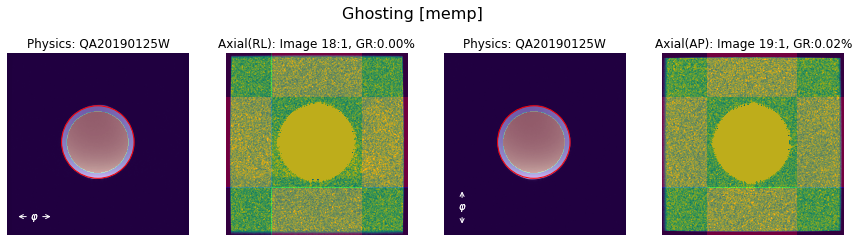

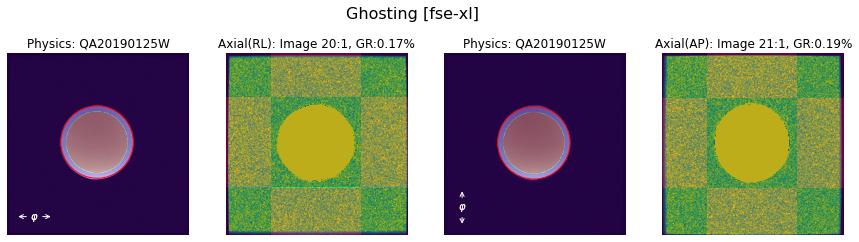

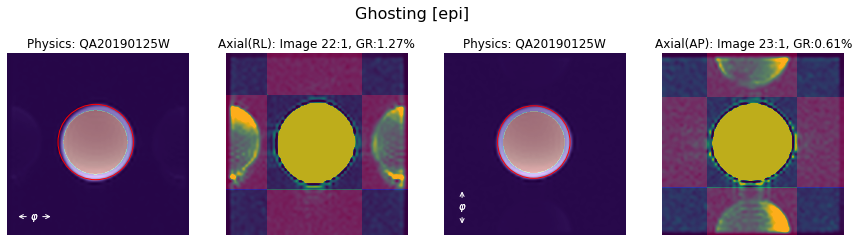

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                      
18         memp       Axial              RL            0.001
19         memp       Axial              AP            0.021
20       fse-xl       Axial              RL            0.169
21       fse-xl       Axial              AP            0.189
22          epi       Axial              RL            1.272
23          epi       Axial              AP            0.612

In [14]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

"""
# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()
"""
with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is over 1% for the EPI with the phase encoding direction right-left.

In [15]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the head coil using a spherical phantom filled with silicone oil. Results are presented both before and after coil sensitivity map based intensity normalisation.

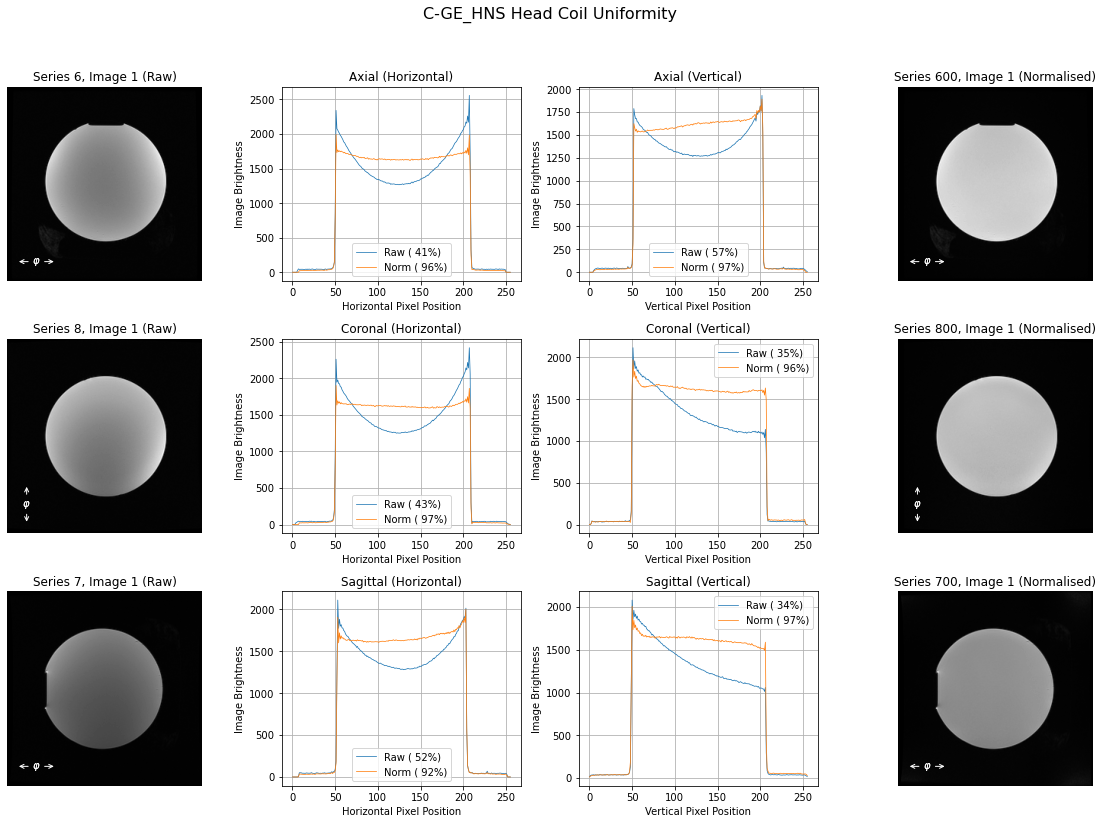

Raw Images


Series No.                Protocol         Axis  \
Orientation                                                    
Axial                 6  Physics: QA20190125WIP     Axial/RL   
Coronal               8  Physics: QA20190125WIP   Coronal/HF   
Sagittal              7  Physics: QA20190125WIP  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    41.25             56.86  
Coronal                  43.40             34.81  
Sagittal                 52.29             34.18

Intensity Normalised Images


Series No.                Protocol         Axis  \
Orientation                                                    
Axial               600  Physics: QA20190125WIP     Axial/RL   
Coronal             800  Physics: QA20190125WIP   Coronal/HF   
Sagittal            700  Physics: QA20190125WIP  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    96.23             97.37  
Coronal                  97.48             96.20  
Sagittal                 92.16             96.86

In [16]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w and w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

results = uniformity_report(
    raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
    psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]]
)

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the manufacturer's intensity normalisation is effective in compensating for this.

In [17]:
NewPage

## Signal to Noise

The Manufacturer's QA involves an element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using a bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image. As no single element images are available This uses subtraction of a pair of combined images.

### 12 Channel Head Coil

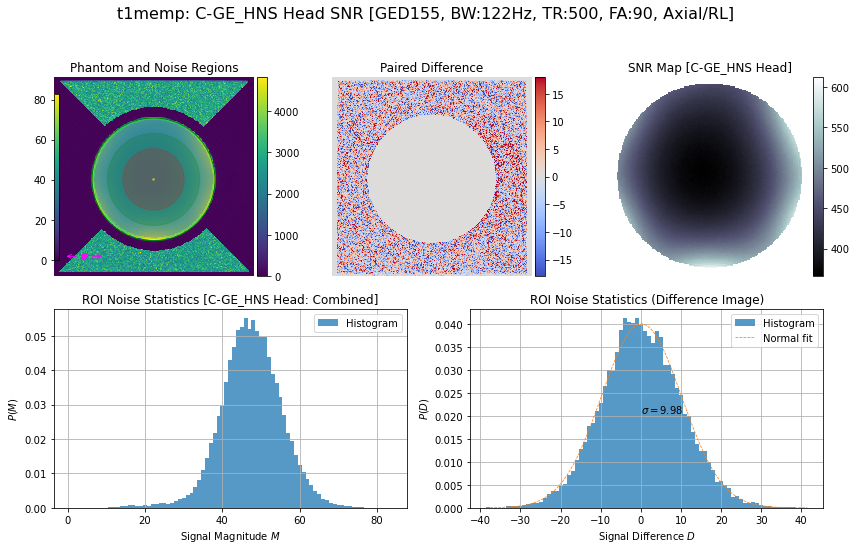

SNR: Raw Images


C-GE_HNS Head
RegionSize               
0.50                388.0
0.75                412.0

In [18]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]], phantom=GED155)
else:
    results = snr_report(raw_dobjs=[raw_tra[0]], phantom=GED155)
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are rather high for a 1.5T scanner with this acquisition - it's likely that there has been some image smoothing in the reconstruction along with the gradient distortion correction, which is apparent.

In [19]:
NewPage

### System Reference Values
These are the reference values reported in the DICOM header of a SE scan.

In [20]:
info = tests['TuneupParams']
patid, studyid, series = info['PatID'], info['StudyID'], info['Series']
series = info['Series']

dobj = fetch_series(patid, studyid, sernos=series)[0]
pd.DataFrame({
    'SoftwareVersions': [software_versions(dobj)],
    'ImagingFrequency': [larmor_frequency(dobj)]
}, index=['Value']).T

Value
SoftwareVersions  27:LX:MR Software release:DV25.1_R03_1802.a
ImagingFrequency                                       63.862